In [1]:
import tensorflow as tf 
import tensorflow_datasets as tfds 
import numpy as np
import matplotlib.pyplot as plt

#### Importazione del dataset da tensorflow_dataset

In [2]:
tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load( 'cats_vs_dogs', 
                                             split = ['train[:40]', 'train[40%:50%]', 'train[50%:60%]'],
                                              as_supervised = True,)

#### Visualizzazione di 9 immagini prese dal dataset disposte in una griglia 3x3

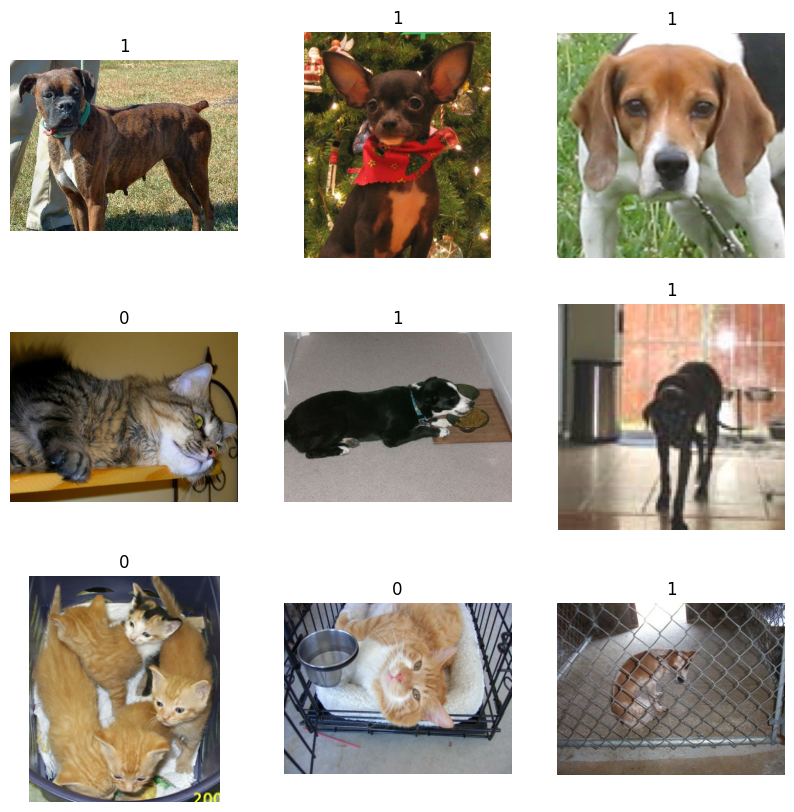

In [3]:
plt.figure(figsize=  (10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis('off')

#### Resize delle immagini in input nelle dimensioni previste dal modello Xception

In [4]:
size = (150, 150)
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

* con il metodo [cache()] impostiamo un caching automatico degli esempi* il metodo [prefetch()] permette a TF di scaricare e preparare i dati per il successivo batch di esempi durante l'addestramento del batch attualeale

In [5]:

batch_size = 32
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

#### Incremento degli esempi tramite una modifica delle immagini originali effettuando un flip orizzontale e una rotazione random da -36 gradi a 36

In [6]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

#### Illustrazione di un immagine modificata 9 volte

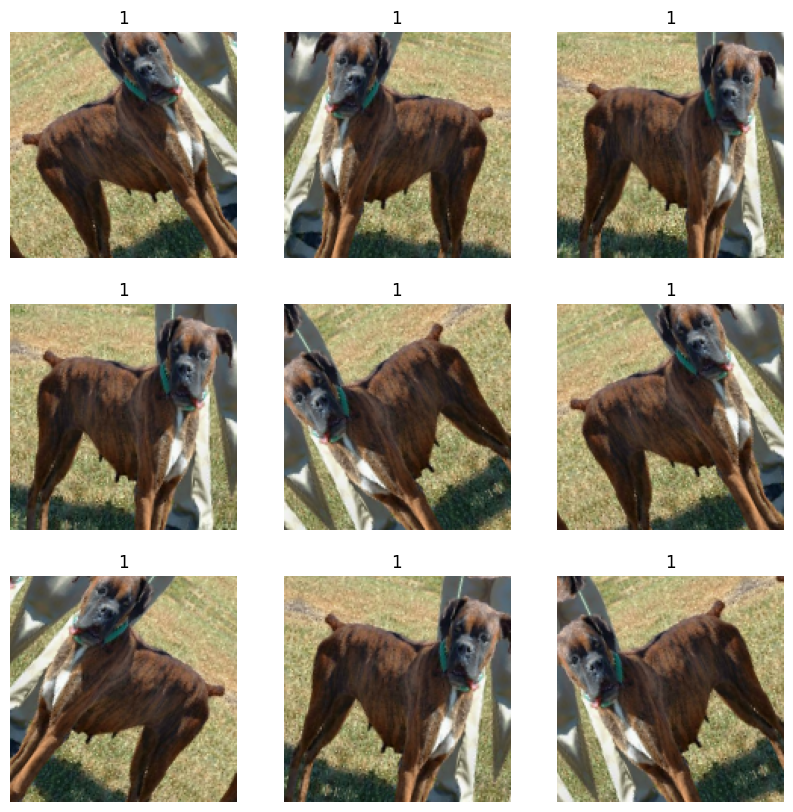

In [7]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10,10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training= True)
        plt.imshow(augmented_image[0].numpy().astype('int32'))
        plt.title(int(labels[0]))
        plt.axis('off')

#### Adattamento modello preaddestrato Xception

In [8]:
base_model = tf.keras.applications.Xception(
    weights = 'imagenet',
    input_shape=(150, 150,3),
    include_top=False
)

base_model.trainable = False 

inputs= tf.keras.layers.Input(shape = (150, 150, 3))
x = data_augmentation(inputs)

scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset= -1)
x = scale_layer(x)

x = base_model(x, training= False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

#### Compilazione e addestramento del modello

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)-

Epoch 1/20
2/2 [==============================] - 92s 88s/step - loss: 0.8337 - binary_accuracy: 0.4750 - val_loss: 0.6325 - val_binary_accuracy: 0.6883
Epoch 2/20
2/2 [==============================] - 91s 89s/step - loss: 0.5484 - binary_accuracy: 0.7000 - val_loss: 0.5850 - val_binary_accuracy: 0.7696
Epoch 3/20
2/2 [==============================] - 88s 87s/step - loss: 0.4380 - binary_accuracy: 0.9000 - val_loss: 0.5364 - val_binary_accuracy: 0.8190
Epoch 4/20
2/2 [==============================] - 87s 86s/step - loss: 0.4116 - binary_accuracy: 0.9000 - val_loss: 0.4693 - val_binary_accuracy: 0.8577
Epoch 5/20
2/2 [==============================] - 87s 85s/step - loss: 0.3182 - binary_accuracy: 0.9750 - val_loss: 0.4022 - val_binary_accuracy: 0.8856
Epoch 6/20
2/2 [==============================] - 87s 86s/step - loss: 0.2870 - binary_accuracy: 0.9250 - val_loss: 0.3470 - val_binary_accuracy: 0.8985
Epoch 7/20
2/2 [==============================] - 89s 87s/step - loss: 0.1999 - bi

#### Riaddestriamo tutto il modello per un fine-tuning finale con un learning rate molto basso 

In [10]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             